# Beyond Least Squares: From Manual to Automatic Differentiation

In this notebook, we'll explore how PyTorch automates gradient computation, making it possible to efficiently optimize complex functions. We'll:
1. Compare manual and automatic gradient computation
2. Understand computational graphs and backpropagation
3. Implement neural networks using PyTorch's automatic differentiation

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchvision import datasets, transforms
import time

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Plotting settings
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'lines.linewidth': 2
})

def plot_tensor(name, x):
    """Print tensor with name and shape."""
    print(f"{name}: shape={x.shape}")
    print(x)

## Manual Gradient Computation: A Simple Example

Let's start with a simple one-dimensional function to understand how gradients are computed:

$$ f(x) = x^3 - 3x $$

We can compute its derivative manually:
$$ \frac{d}{dx}f(x) = 3x^2 - 3 $$

Let's implement both the function and its gradient:

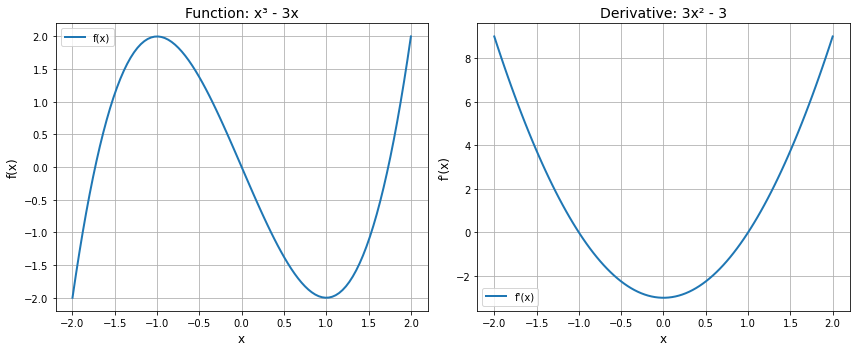

In [2]:
def f(x):
    """Compute f(x) = x³ - 3x"""
    return x**3 - 3*x

def df(x):
    """Compute f'(x) = 3x² - 3"""
    return 3*x**2 - 3

# Test points
x = torch.linspace(-2, 2, 100)
y = f(x)
dy = df(x)

# Plot function and its derivative
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(x, y, label='f(x)')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function: x³ - 3x')
plt.legend()

plt.subplot(122)
plt.plot(x, dy, label="f'(x)")
plt.grid(True)
plt.xlabel('x')
plt.ylabel("f'(x)")
plt.title('Derivative: 3x² - 3')
plt.legend()

plt.tight_layout()
plt.show()

### Understanding the Computational Graph

The function $f(x) = x^3 - 3x$ can be broken down into a sequence of simpler operations:
1. $z_1 = x^3$ (power operation)
2. $z_2 = -3x$ (multiplication)
3. $f = z_1 + z_2$ (addition)

Each operation has a simple local derivative:
- For $z_1$: $\frac{\partial z_1}{\partial x} = 3x^2$
- For $z_2$: $\frac{\partial z_2}{\partial x} = -3$
- For $f$: $\frac{\partial f}{\partial z_1} = 1$, $\frac{\partial f}{\partial z_2} = 1$

Let's visualize this computation:

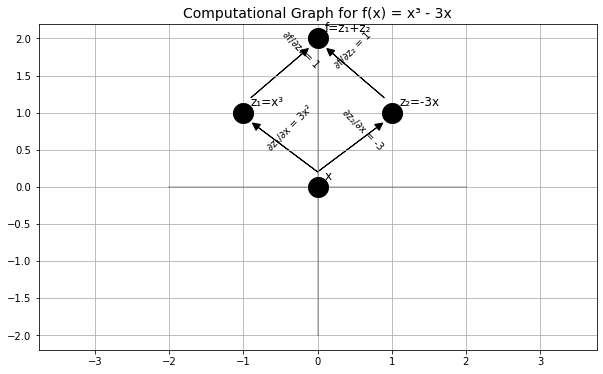

In [3]:
def plot_computation_graph():
    """Plot the computational graph for f(x) = x³ - 3x"""
    plt.figure(figsize=(10, 6))
    
    # Create graph layout
    plt.plot([-2, 2], [0, 0], 'k-', alpha=0.2)  # x-axis
    plt.plot([0, 0], [-2, 2], 'k-', alpha=0.2)  # y-axis
    
    # Nodes
    plt.plot(0, 0, 'ko', markersize=20, label='Node')
    plt.text(0.1, 0.1, 'x', fontsize=12)
    
    plt.plot(-1, 1, 'ko', markersize=20)
    plt.text(-0.9, 1.1, 'z₁=x³', fontsize=12)
    
    plt.plot(1, 1, 'ko', markersize=20)
    plt.text(1.1, 1.1, 'z₂=-3x', fontsize=12)
    
    plt.plot(0, 2, 'ko', markersize=20)
    plt.text(0.1, 2.1, 'f=z₁+z₂', fontsize=12)
    
    # Edges
    plt.arrow(0, 0.2, -0.8, 0.6, head_width=0.1, head_length=0.1, fc='k', ec='k')
    plt.arrow(0, 0.2, 0.8, 0.6, head_width=0.1, head_length=0.1, fc='k', ec='k')
    plt.arrow(-0.9, 1.2, 0.7, 0.6, head_width=0.1, head_length=0.1, fc='k', ec='k')
    plt.arrow(0.9, 1.2, -0.7, 0.6, head_width=0.1, head_length=0.1, fc='k', ec='k')
    
    # Add derivative labels
    plt.text(-0.7, 0.5, '∂z₁/∂x = 3x²', fontsize=10, rotation=45)
    plt.text(0.3, 0.5, '∂z₂/∂x = -3', fontsize=10, rotation=-45)
    plt.text(-0.5, 1.6, '∂f/∂z₁ = 1', fontsize=10, rotation=-45)
    plt.text(0.2, 1.6, '∂f/∂z₂ = 1', fontsize=10, rotation=45)
    
    plt.title('Computational Graph for f(x) = x³ - 3x')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

plot_computation_graph() 

## Automatic Differentiation with PyTorch

Now let's see how PyTorch automates this gradient computation:

In [4]:
# Create input tensor with gradient tracking
x = torch.tensor([1.0], requires_grad=True)

# Forward pass
z1 = x**3
z2 = -3*x
f = z1 + z2

# Backward pass
f.backward()

print(f"Manual gradient at x=1: {df(torch.tensor([1.0]))}")
print(f"PyTorch gradient at x=1: {x.grad}")

Manual gradient at x=1: tensor([0.])
PyTorch gradient at x=1: tensor([0.])


Let's compare manual and automatic gradients over a range of values:

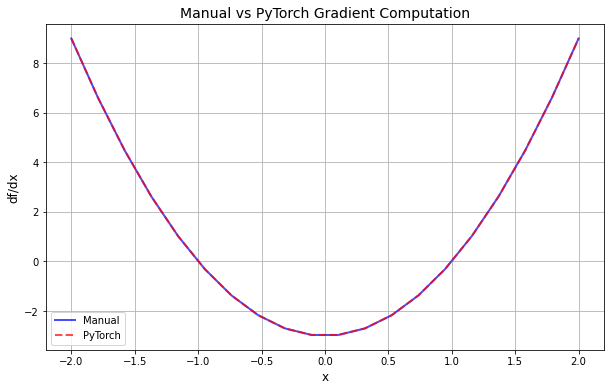

/Users/damek/.pyenv/versions/3.10.4/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


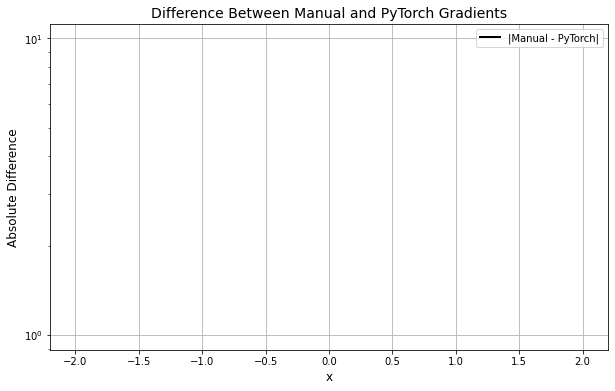

In [5]:
def compare_gradients(x_range):
    """Compare manual and automatic gradient computation"""
    results = []
    for x_val in x_range:
        # PyTorch computation
        x = torch.tensor([float(x_val)], requires_grad=True)
        f = x**3 - 3*x
        f.backward()
        auto_grad = x.grad.item()
        
        # Manual computation
        manual_grad = df(torch.tensor([x_val])).item()
        
        results.append((x_val, manual_grad, auto_grad))
    
    return zip(*results)

# Generate comparison data
x_vals = torch.linspace(-2, 2, 20)
x_points, manual_grads, auto_grads = compare_gradients(x_vals)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(x_points, manual_grads, 'b-', label='Manual', alpha=0.7)
plt.plot(x_points, auto_grads, 'r--', label='PyTorch', alpha=0.7)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('df/dx')
plt.title('Manual vs PyTorch Gradient Computation')
plt.legend()
plt.show()

# Compute and plot absolute difference
diff = np.abs(np.array(manual_grads) - np.array(auto_grads))
plt.figure(figsize=(10, 6))
plt.semilogy(x_points, diff, 'k-', label='|Manual - PyTorch|')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('Absolute Difference')
plt.title('Difference Between Manual and PyTorch Gradients')
plt.legend()
plt.show()

### How PyTorch Builds the Computational Graph

PyTorch builds the computational graph dynamically during the forward pass. Let's visualize this process:

In [6]:
def trace_computation(x_val):
    """Trace computation with intermediate values"""
    x = torch.tensor([x_val], requires_grad=True)
    print(f"Input x: {x.item()}")
    
    # First operation: x³
    z1 = x**3
    print(f"z₁ = x³: {z1.item()}")
    
    # Second operation: -3x
    z2 = -3*x
    print(f"z₂ = -3x: {z2.item()}")
    
    # Final operation: z₁ + z₂
    f = z1 + z2
    print(f"f = z₁ + z₂: {f.item()}")
    
    # Compute gradient
    f.backward()
    print(f"df/dx: {x.grad.item()}")
    
    return x, z1, z2, f

# Trace computation for x = 2
print("Tracing computation for x = 2:")
x, z1, z2, f = trace_computation(2.0)

# Print computational graph structure
def print_graph_structure(tensor, prefix=""):
    """Print the computational graph structure"""
    if tensor.grad_fn is not None:
        print(f"{prefix}Operation: {type(tensor.grad_fn).__name__}")
        if hasattr(tensor.grad_fn, 'next_functions'):
            for next_fn in tensor.grad_fn.next_functions:
                if next_fn[0] is not None:
                    try:
                        next_tensor = next_fn[0].variable
                        print_graph_structure(next_tensor, prefix + "  ")
                    except AttributeError:
                        # Skip if variable not accessible
                        continue

print("\nComputational graph structure:")
print_graph_structure(f)

Tracing computation for x = 2:
Input x: 2.0
z₁ = x³: 8.0
z₂ = -3x: -6.0
f = z₁ + z₂: 2.0
df/dx: 9.0

Computational graph structure:
Operation: AddBackward0


## Least Squares with Automatic Differentiation

Let's apply automatic differentiation to a more practical example: least squares regression. We'll minimize:

$$ f(w) = \frac{1}{2}\|Xw - y\|^2 $$

First, let's create some synthetic data:

In [7]:
# Generate synthetic data
n, p = 100, 5  # 100 samples, 5 features
X = torch.randn(n, p)
w_true = torch.randn(p)
y = X @ w_true + 0.1 * torch.randn(n)

# Split visualization for 2D case
def plot_2d_data(X, y):
    plt.figure(figsize=(10, 5))
    plt.scatter(X[:, 0], y, alpha=0.5, label='Data')
    plt.xlabel('First feature')
    plt.ylabel('Target')
    plt.title('Data visualization (first feature only)')
    plt.legend()
    plt.grid(True)
    plt.show()

if p == 2:  # Only plot if 2D
    plot_2d_data(X, y)

### Manual Implementation

First, let's implement gradient descent with manual gradient computation:

In [8]:
def manual_gradient_descent(X, y, n_steps=100, alpha=0.01):
    """Minimize least squares with manual gradient computation"""
    n, p = X.shape
    w = torch.zeros(p)
    losses = []
    
    for step in range(n_steps):
        # Compute gradient: X^T(Xw - y)
        grad = X.T @ (X @ w - y)
        
        # Update weights
        w = w - alpha * grad
        
        # Track loss
        loss = 0.5 * torch.sum((X @ w - y)**2)
        losses.append(loss.item())
    
    return w, losses

# Run manual gradient descent
start_time = time.time()
w_manual, losses_manual = manual_gradient_descent(X, y)
manual_time = time.time() - start_time

### PyTorch Implementation

Now let's use PyTorch's automatic differentiation:

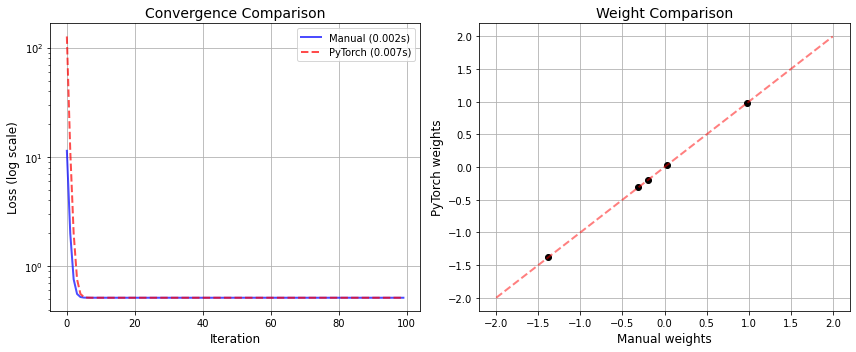

In [9]:
def pytorch_gradient_descent(X, y, n_steps=100, alpha=0.01):
    """Minimize least squares with PyTorch's autograd"""
    n, p = X.shape
    w = torch.zeros(p, requires_grad=True)
    losses = []
    
    for step in range(n_steps):
        # Forward pass
        pred = X @ w
        loss = 0.5 * torch.sum((pred - y)**2)
        
        # Backward pass
        loss.backward()
        
        # Update weights (need to detach from graph)
        with torch.no_grad():
            w.data = w.data - alpha * w.grad
            w.grad.zero_()
        
        losses.append(loss.item())
    
    return w, losses

# Run PyTorch gradient descent
start_time = time.time()
w_pytorch, losses_pytorch = pytorch_gradient_descent(X, y)
pytorch_time = time.time() - start_time

# Compare results
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.semilogy(losses_manual, 'b-', label=f'Manual ({manual_time:.3f}s)', alpha=0.7)
plt.semilogy(losses_pytorch, 'r--', label=f'PyTorch ({pytorch_time:.3f}s)', alpha=0.7)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Convergence Comparison')
plt.legend()

plt.subplot(122)
plt.plot(w_manual, w_pytorch.detach(), 'ko')
plt.plot([-2, 2], [-2, 2], 'r--', alpha=0.5)  # Perfect agreement line
plt.grid(True)
plt.xlabel('Manual weights')
plt.ylabel('PyTorch weights')
plt.title('Weight Comparison')

plt.tight_layout()
plt.show()

### Understanding the Computational Graph

Let's visualize the computational graph for least squares:

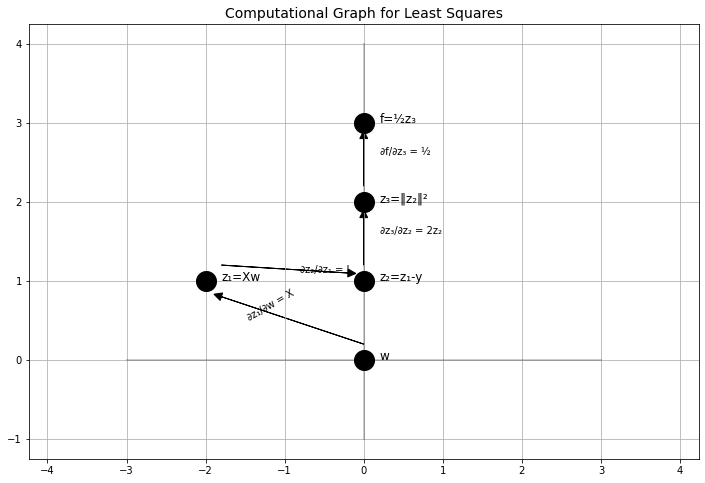

In [10]:
def plot_least_squares_graph():
    """Plot computational graph for least squares"""
    plt.figure(figsize=(12, 8))
    
    # Create graph layout
    plt.plot([-3, 3], [0, 0], 'k-', alpha=0.2)  # x-axis
    plt.plot([0, 0], [-1, 4], 'k-', alpha=0.2)  # y-axis
    
    # Nodes
    def add_node(x, y, label):
        plt.plot(x, y, 'ko', markersize=20)
        plt.text(x+0.2, y, label, fontsize=12)
    
    # Add nodes
    add_node(0, 0, 'w')  # Input
    add_node(-2, 1, 'z₁=Xw')  # Matrix multiply
    add_node(0, 1, 'z₂=z₁-y')  # Subtract
    add_node(0, 2, 'z₃=‖z₂‖²')  # Square norm
    add_node(0, 3, 'f=½z₃')  # Scale
    
    # Edges with derivatives
    plt.arrow(0, 0.2, -1.8, 0.6, head_width=0.1, head_length=0.1, fc='k', ec='k')
    plt.arrow(-1.8, 1.2, 1.6, -0.1, head_width=0.1, head_length=0.1, fc='k', ec='k')
    plt.arrow(0, 1.2, 0, 0.6, head_width=0.1, head_length=0.1, fc='k', ec='k')
    plt.arrow(0, 2.2, 0, 0.6, head_width=0.1, head_length=0.1, fc='k', ec='k')
    
    # Add derivative labels
    plt.text(-1.5, 0.5, '∂z₁/∂w = X', fontsize=10, rotation=30)
    plt.text(-0.8, 1.1, '∂z₂/∂z₁ = I', fontsize=10)
    plt.text(0.2, 1.6, '∂z₃/∂z₂ = 2z₂', fontsize=10)
    plt.text(0.2, 2.6, '∂f/∂z₃ = ½', fontsize=10)
    
    plt.title('Computational Graph for Least Squares')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

plot_least_squares_graph()

## Neural Networks with PyTorch

Finally, let's see how automatic differentiation enables training of neural networks. We'll implement a simple binary classifier on the MNIST dataset:

In [11]:
# Display some examples
def plot_examples(dataset, n_examples=5):
    """Plot example images with their labels"""
    plt.figure(figsize=(15, 3))
    for i in range(n_examples):
        plt.subplot(1, n_examples, i+1)
        plt.imshow(dataset[i][0].squeeze(), cmap='gray')
        plt.title(f"Label: {'Odd' if dataset[i][1] else 'Even'}")
        plt.axis('off')
    plt.show()

### Loading and Preprocessing Data

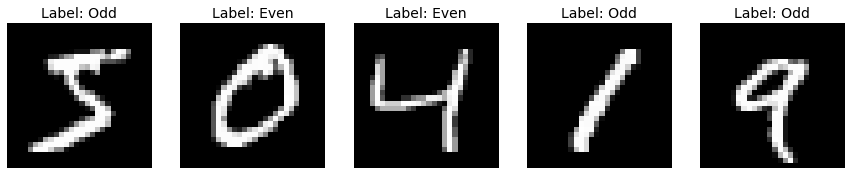

In [12]:
# Load and preprocess MNIST data
def load_mnist_binary():
    """Load MNIST and convert to binary classification (odd vs even)"""
    try:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        
        # Load training data
        train_dataset = datasets.MNIST('./data', train=True, download=True,
                                     transform=transform)
        
        # Convert to binary classification (odd vs even)
        train_dataset.targets = (train_dataset.targets % 2).float()
        
        return train_dataset
    except Exception as e:
        print(f"Error loading MNIST data: {e}")
        return None

# Load data
train_dataset = load_mnist_binary()
if train_dataset is not None:
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
    plot_examples(train_dataset)
else:
    print("Failed to load MNIST data. Skipping neural network examples.")

### Model Implementation

In [13]:
# Model definitions
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 1)  # 28x28 = 784 input features
    
    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input
        return torch.sigmoid(self.linear(x))

class SimpleNN(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

### Training Loop

In [14]:
# Training function
def train_model(model, train_loader, n_epochs=3, learning_rate=0.01):
    """Train model using binary cross entropy loss"""
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    
    train_losses = []
    train_accuracies = []
    
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            # Forward pass
            output = model(data)
            target = target.float()  # Convert target to float
            loss = criterion(output.squeeze(), target)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track metrics
            epoch_loss += loss.item()
            pred = (output.squeeze() > 0.5).float()
            correct += (pred == target).sum().item()
            total += target.size(0)
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
        
        # Record epoch metrics
        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)
        
        print(f'Epoch {epoch}: Average loss = {train_losses[-1]:.4f}, '
              f'Accuracy = {train_accuracies[-1]:.2f}%')
    
    return train_losses, train_accuracies

### Training Models


Training Logistic...
Epoch: 0, Batch: 0, Loss: 0.6677


Epoch: 0, Batch: 100, Loss: 0.3361


Epoch: 0, Batch: 200, Loss: 0.3731


Epoch: 0, Batch: 300, Loss: 0.2316


Epoch: 0, Batch: 400, Loss: 0.2818


Epoch: 0, Batch: 500, Loss: 0.2795


Epoch 0: Average loss = 0.3235, Accuracy = 86.25%
Epoch: 1, Batch: 0, Loss: 0.3727


Epoch: 1, Batch: 100, Loss: 0.2689


Epoch: 1, Batch: 200, Loss: 0.2464


Epoch: 1, Batch: 300, Loss: 0.3452


Epoch: 1, Batch: 400, Loss: 0.2960


Epoch: 1, Batch: 500, Loss: 0.3233


Epoch 1: Average loss = 0.2867, Accuracy = 88.16%
Epoch: 2, Batch: 0, Loss: 0.2439


Epoch: 2, Batch: 100, Loss: 0.3094


Epoch: 2, Batch: 200, Loss: 0.2139


Epoch: 2, Batch: 300, Loss: 0.2968


Epoch: 2, Batch: 400, Loss: 0.3778


Epoch: 2, Batch: 500, Loss: 0.3132


Epoch 2: Average loss = 0.2782, Accuracy = 88.61%

Training Neural Net...
Epoch: 0, Batch: 0, Loss: 0.7027


Epoch: 0, Batch: 100, Loss: 0.4076


Epoch: 0, Batch: 200, Loss: 0.3601


Epoch: 0, Batch: 300, Loss: 0.2414


Epoch: 0, Batch: 400, Loss: 0.2440


Epoch: 0, Batch: 500, Loss: 0.3237


Epoch 0: Average loss = 0.3376, Accuracy = 86.25%
Epoch: 1, Batch: 0, Loss: 0.2892


Epoch: 1, Batch: 100, Loss: 0.2591


Epoch: 1, Batch: 200, Loss: 0.3733


Epoch: 1, Batch: 300, Loss: 0.2537


Epoch: 1, Batch: 400, Loss: 0.2057


Epoch: 1, Batch: 500, Loss: 0.1732


Epoch 1: Average loss = 0.2237, Accuracy = 91.53%
Epoch: 2, Batch: 0, Loss: 0.1739


Epoch: 2, Batch: 100, Loss: 0.1837


Epoch: 2, Batch: 200, Loss: 0.1879


Epoch: 2, Batch: 300, Loss: 0.1559


Epoch: 2, Batch: 400, Loss: 0.1786


Epoch: 2, Batch: 500, Loss: 0.2430


Epoch 2: Average loss = 0.1698, Accuracy = 94.09%


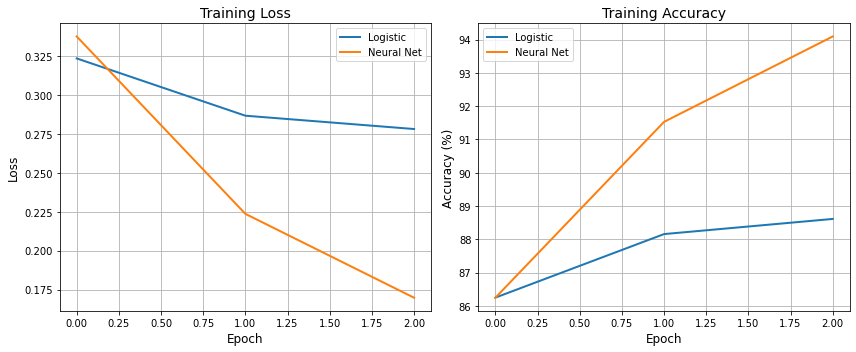

In [15]:
# Train models if data is available
if 'train_loader' in locals():
    # Initialize models
    models = {
        'Logistic': LogisticRegression(),
        'Neural Net': SimpleNN()
    }

    # Train models
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        losses, accuracies = train_model(model, train_loader)
        results[name] = {'losses': losses, 'accuracies': accuracies}

    # Plot training curves
    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    for name, res in results.items():
        plt.plot(res['losses'], label=name)
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(122)
    for name, res in results.items():
        plt.plot(res['accuracies'], label=name)
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Visualizing the Neural Network

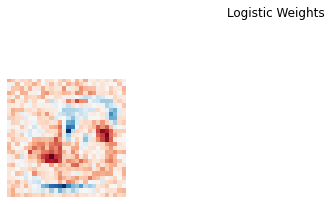

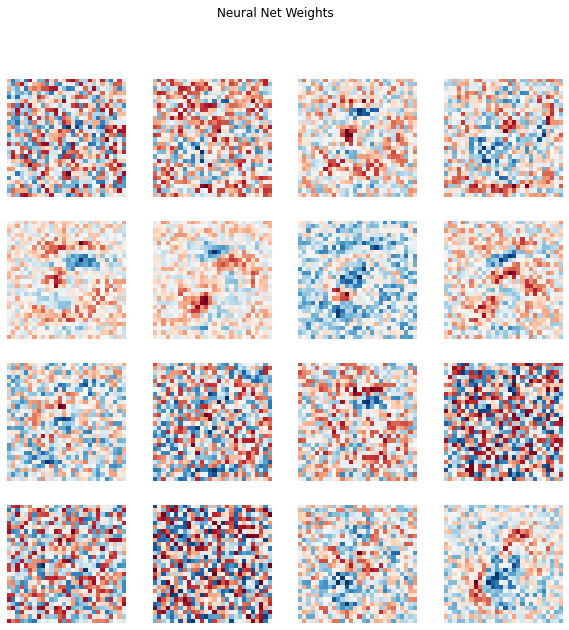

In [16]:
# Visualize weights if models were trained
if 'models' in locals():
    def plot_weights(model, title):
        """Plot the weights of the first layer as images"""
        if isinstance(model, LogisticRegression):
            weights = model.linear.weight.detach().reshape(-1, 28, 28)
        else:
            weights = model.fc1.weight.detach()[:16].reshape(-1, 28, 28)
        
        n = min(16, len(weights))
        plt.figure(figsize=(10, 10))
        for i in range(n):
            plt.subplot(4, 4, i+1)
            plt.imshow(weights[i], cmap='RdBu')
            plt.axis('off')
        plt.suptitle(f'{title} Weights')
        plt.show()

    for name, model in models.items():
        plot_weights(model, name)

### Understanding the Computational Graph

In [17]:
# Trace network structure if models were trained
if 'models' in locals():
    def trace_network(model, input_shape=(1, 1, 28, 28)):
        """Trace a forward pass through the network"""
        x = torch.zeros(input_shape, requires_grad=True)
        y = model(x)
        
        def print_graph_structure(tensor, prefix=""):
            """Print the computational graph structure"""
            if tensor.grad_fn is not None:
                print(f"{prefix}Operation: {type(tensor.grad_fn).__name__}")
                if hasattr(tensor.grad_fn, 'next_functions'):
                    for next_fn in tensor.grad_fn.next_functions:
                        if next_fn[0] is not None:
                            try:
                                next_tensor = next_fn[0].variable
                                print_graph_structure(next_tensor, prefix + "  ")
                            except AttributeError:
                                # Some operations don't have variables, just print their type
                                print(f"{prefix}  Operation: {type(next_fn[0]).__name__}")
        
        print(f"\nComputational graph for {type(model).__name__}:")
        print_graph_structure(y)

    for name, model in models.items():
        trace_network(model)


Computational graph for LogisticRegression:
Operation: SigmoidBackward0
  Operation: AddmmBackward0

Computational graph for SimpleNN:
Operation: SigmoidBackward0
  Operation: AddmmBackward0
